[[ 1.         -1.         -1.          0.          0.          5.54517744
   0.          1.38629436  8.04718956  5.54517744  8.04718956 16.63553233]
 [ 1.          0.         -1.          0.          0.          0.
   1.38629436  0.          1.38629436  8.04718956  5.54517744  8.04718956]
 [ 1.          1.         -1.          5.54517744  0.          0.
   8.04718956  1.38629436  0.         16.63553233  8.04718956  5.54517744]
 [ 1.         -1.          0.          0.          1.38629436  8.04718956
   0.          0.          5.54517744  0.          1.38629436  8.04718956]
 [ 1.          0.          0.          1.38629436  0.          1.38629436
   0.          0.          0.          1.38629436  0.          1.38629436]
 [ 1.          1.          0.          8.04718956  1.38629436  0.
   5.54517744  0.          0.          8.04718956  1.38629436  0.        ]
 [ 1.         -1.          1.          5.54517744  8.04718956 16.63553233
   0.          1.38629436  8.04718956  0.          0.   

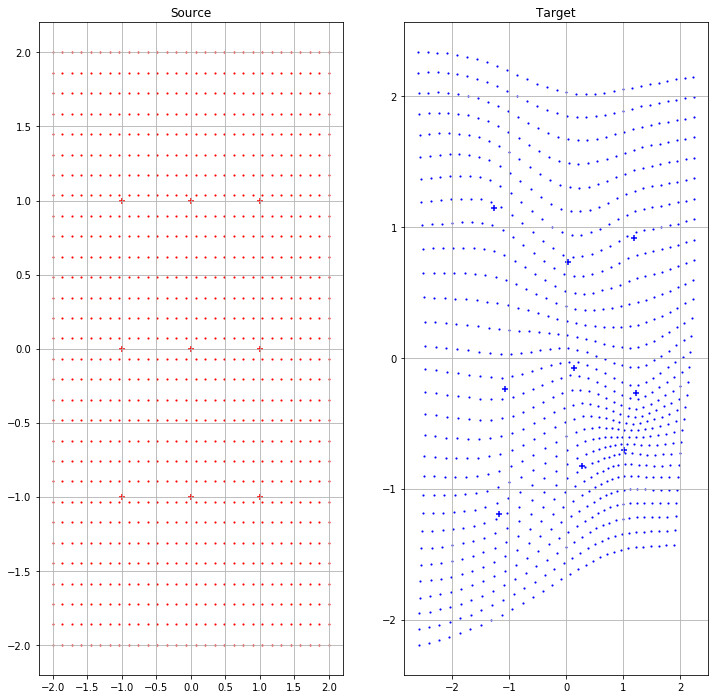

In [11]:
import ipdb
import numpy as np
import numpy.linalg as nl
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist, squareform

def makeT(cp):
    # cp: [K x 2] control points
    # T: [(K+3) x (K+3)]
    K = cp.shape[0]
    T = np.zeros((K+3, K+3))
    T[:K, 0] = 1
    T[:K, 1:3] = cp
    T[K, 3:] = 1
    T[K+1:, 3:] = cp.T
    R = squareform(pdist(cp, metric='euclidean'))
    R = R * R
    R[R == 0] = 1 # a trick to make R ln(R) 0
    R = R * np.log(R)
    np.fill_diagonal(R, 0)
    T[:K, 3:] = R
    return T

def liftPts(p, cp):
    # p: [N x 2], input points
    # cp: [K x 2], control points
    # pLift: [N x (3+K)], lifted input points
    N, K = p.shape[0], cp.shape[0]
    pLift = np.zeros((N, K+3))
    pLift[:,0] = 1
    pLift[:,1:3] = p
    R = cdist(p, cp, 'euclidean')
    R = R * R
    R[R == 0] = 1
    R = R * np.log(R)
    pLift[:,3:] = R
    return pLift

# source control points
x, y = np.linspace(-1, 1, 3), np.linspace(-1, 1, 3)
x, y = np.meshgrid(x, y)
xs = x.flatten()
ys = y.flatten()
cps = np.vstack([xs, ys]).T


# target control points
xt = xs + np.random.uniform(-0.3, 0.3, size=xs.size)
yt = ys + np.random.uniform(-0.3, 0.3, size=ys.size)

# construct T
T = makeT(cps)
print(T)
# solve cx, cy (coefficients for x and y)
xtAug = np.concatenate([xt, np.zeros(3)])
ytAug = np.concatenate([yt, np.zeros(3)])
cx = nl.solve(T, xtAug) # [K+3]
cy = nl.solve(T, ytAug)

# dense grid
N = 30
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, N)
x, y = np.meshgrid(x, y)
xgs, ygs = x.flatten(), y.flatten()

gps = np.vstack([xgs, ygs]).T

# transform
pgLift = liftPts(gps, cps) # [N x (K+3)]
xgt = np.dot(pgLift, cx.T)
ygt = np.dot(pgLift, cy.T)

# display
%matplotlib inline

plt.figure(figsize=(12,12))
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.subplot(1, 2, 1)
plt.title('Source')
plt.grid()
plt.scatter(xs, ys, marker='+', c='r', s=40)
plt.scatter(xgs, ygs, marker='.', c='r', s=5)
plt.subplot(1, 2, 2)
plt.title('Target')
plt.grid()
plt.scatter(xt, yt, marker='+', c='b', s=40)
plt.scatter(xgt, ygt, marker='.', c='b', s=5)
# plt.show()